In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
# if one module is changed, this line will automatically reload that module
%load_ext autoreload
%autoreload 2

import torch
import argparse
import numpy as np
import anndata as ad
from scipy.io import savemat, loadmat
import pandas as pd
import warnings;
warnings.filterwarnings('ignore');
import os
import random
import scanpy as sc
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

import sys  
sys.path.insert(0, './ETM/')
sys.path.insert(0, './aux/')
import etm
import data
from utils import *
from aux import *
from plotting import *

In [2]:
fname='./data/Baron/human_pancreas_cluster_labels.csv'
clust=pd.read_csv(fname)# Load cell cluster labels

In [3]:
# Load model
emb=400
I=0.45
rho=0.1
sourceDir='./output/Baron/'+str(emb)+'emb/I-'+str(I)+'_rho-'+str(rho)+'/'
model, theta = load_etm_model(sourceDir)

Model file loaded.
Embeddings (theta): loaded


### Display the model's learned topic composition

In [14]:
show_topics(model, 50, sourceDir)

Vocabulary size: 3036
****************************************************************************************************
VAL Doc Completion PPL: 617.7
****************************************************************************************************

The 10 most used topics are [24 31 15 42 26 19 44 48  4  8]


Topic 0: ['C6', 'SMOC1', 'KCNJ16', 'SFTPA1', 'CNTN1', 'SEMA3G', 'KIF5C', 'MYOM1', 'MYCT1']
Topic 1: ['LY6H', 'CBLN4', 'LEPR', 'THBD', 'LIF', 'PGK1', 'ITGB1', 'BCHE', 'CLEC14A']
Topic 2: ['ANXA1', 'MMP9', 'CFD', 'BCL2A1', 'SLC2A5', 'ABCA1', 'CD83', 'CSF3', 'ARRB2']
Topic 3: ['HMGA1', 'SGK1', 'SEC14L1', 'SERPINI2', 'HPCAL1', 'CREB5', 'LAMC2', 'ISG20', 'TACSTD2']
Topic 4: ['KRT86', 'PEG3', 'ZNF331', 'ADCY1', 'SLC6A19', 'GCNT1', 'TSPAN2', 'MT1H', 'CNTN1']
Topic 5: ['MAF', 'SDR16C5', 'SEPP1', 'FOXD4L5', 'CXCL11', 'F8', 'ABCB11', 'ZCCHC12', 'ACCS']
Topic 6: ['ANXA1', 'MMP9', 'CSF3', 'CFD', 'ABCA1', 'APOL1', 'ABI3BP', 'IL33', 'GLIPR1']
Topic 7: ['FLNB', 'MCTP2', 'SLC15A4', 'WDR86',

### Each cell is represented as a mixture of 50 topics (and each topic is a mixture of genes). Therefore, the embedded topic model serves as for dimensionality reduction. We use the topic representation for downstream analysis and see if the embedded representation of topics and genes provide additional insights.

### First, we perform cell clustering using k-Means, Leiden and Agglomerative Clustering. We measure cluster inference accuracy via ARI and NMI scores using the true cluster labels.

In [11]:
print(f'{emb} embeddings, I_threshold={I}, rho={rho} ')
adata=None
adata=ad.AnnData(obs=clust)
embedding_key='theta'
adata.obsm[embedding_key]=theta

res = np.arange(0.01,1.0,0.01)
scores=evaluate(adata, cell_type_col='assigned_cluster', leiden_resolutions=res, save_as=None, save_scores=False)

400 embeddings, I_threshold=0.4, rho=0.1 
No clustering method specified. Applying all methods: k-means, Aff Prop, Aglomerative, and Leiden
kMeans         :	ARI:  0.6070	NMI:  0.7347
Agglomerative  :	ARI:  0.6520	NMI:  0.7523
Leiden         :	ARI:  0.8446	NMI:  0.8047	Resolution:  0.0200


In [7]:
baron_scores={'emb':emb, 'I':I, 'rho':rho, 'scores':scores} #Saving clustering scores
baron_scores

{'emb': 400,
 'I': 0.45,
 'rho': 0.1,
 'scores': {'kmeans': {'ari': 0.6275337181331181, 'nmi': 0.7218902425814491},
  'AG': {'ari': 0.6742869479805162, 'nmi': 0.7284637856030227},
  'Leiden': {'ari': 0.8326548577478442,
   'nmi': 0.7931910244398489,
   'res': 0.04}}}

In [8]:
np.save('./output/clustering-scores/baron', baron_scores)

### A visualization of the topic-cells using UMAP. We'll use this visual representation to support the analysis.

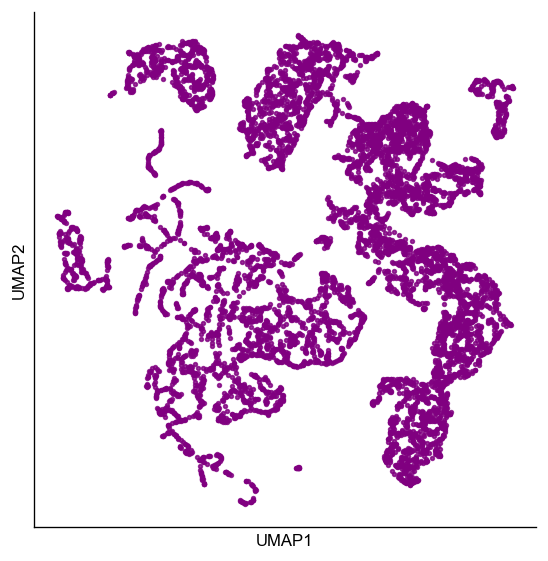

In [4]:
cell_umap=plot_cells_umap(theta)

### We cluster the UMAP representation using agglomerative clustering to explore the spatial distribution of the topic-cells with respect to the true labels. Each color represents an inferred cluster:

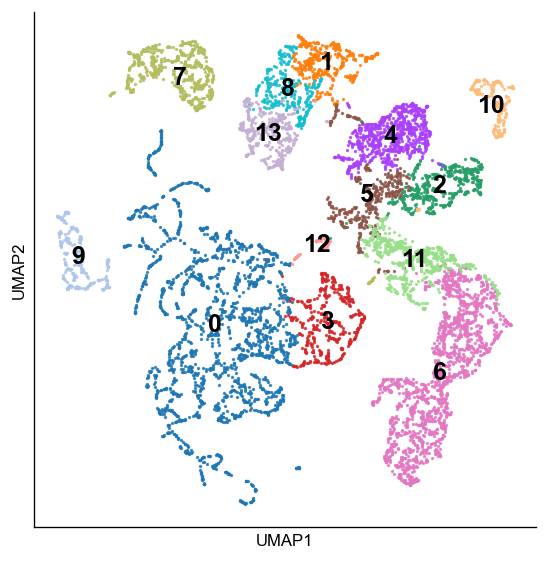

In [17]:
pred_labels=plot_cell_agglomerative_clustering(clust, theta, cell_umap, fpath='./Plots/cell_cluster_getm_baron')

### Compare the clusters with the same data, now colored with respect to the true cell labels. We observe that the inferred clusters from the plot above recover to a good extent the true populations:

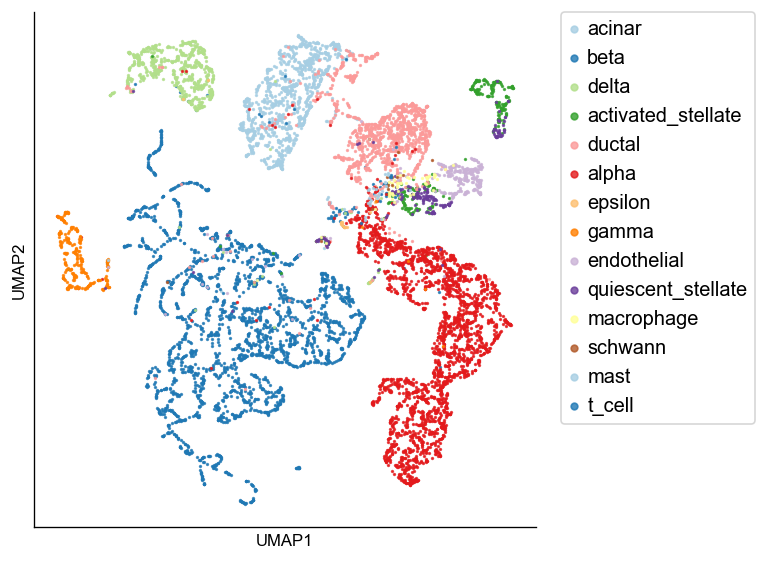

In [15]:
plot_cell_types_umap(cell_umap, clust, fpath='./Plots/cell_types_getm_baron')

### Following, we use a heatmap to examine the topic intensity of each cluster. We try to see if clusters are dominated by specific topics:

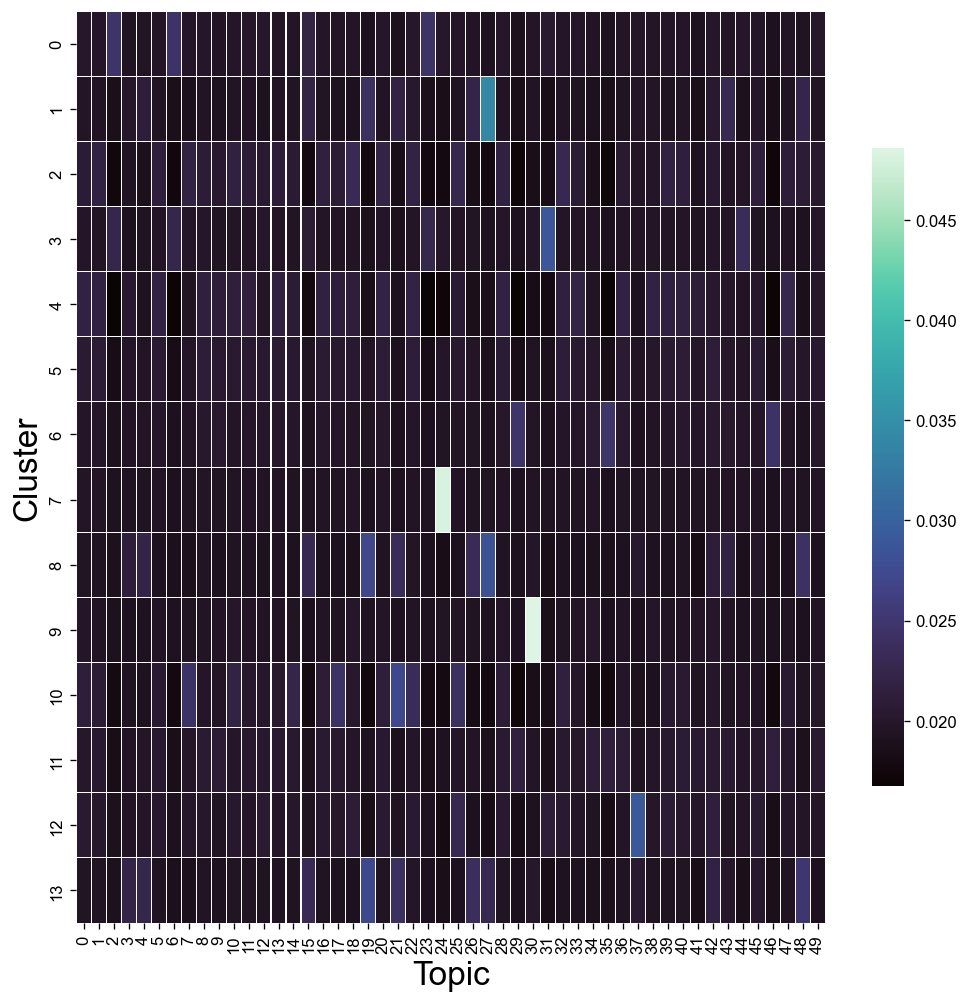

In [88]:
topic_intensity_heatmap(theta, pred_labels, name='human')

### We can examine the topic intensity in the topic-cells. For example, according to the heatmap, topic 24 dominates cluster 7. This can suggest that the genes in topic 24 are more relevant for cells in cluster 7 (corresponding to delta cells):

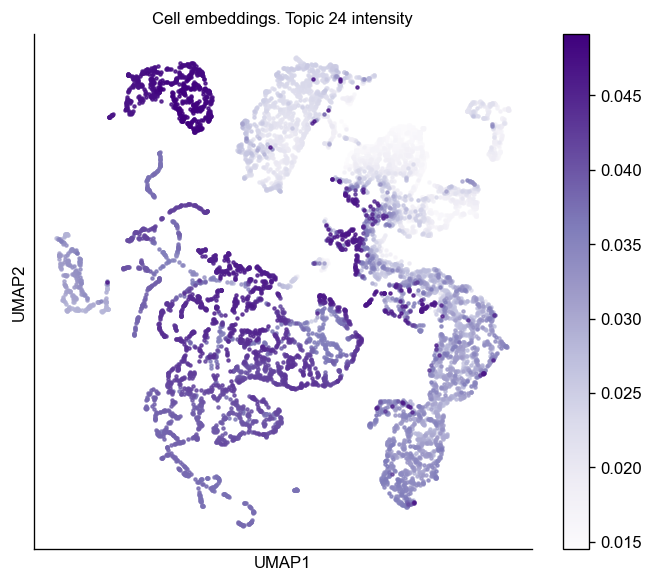

In [36]:
topic_intensity_scatter(24, cell_umap, theta)

In [9]:
#New dataframe used in the following analysis
cell_topics=clust.copy()

for i in range(theta.shape[1]):
        cell_topics['topic'+str(i)]=theta[:,i]
        
cell_topics

,Unnamed: 0,assigned_cluster,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,...,topic40,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49
0,human1_lib1.final_cell_0001,acinar,0.019381,0.019211,0.018713,0.021669,0.021486,0.019105,0.018708,0.018704,...,0.019270,0.017719,0.020754,0.023191,0.018949,0.019805,0.018534,0.018989,0.025096,0.019122
1,human1_lib1.final_cell_0002,acinar,0.019468,0.019394,0.018697,0.020238,0.020915,0.019159,0.018696,0.018746,...,0.019438,0.017967,0.020067,0.025188,0.018976,0.019669,0.018428,0.018984,0.023113,0.019309
2,human1_lib1.final_cell_0003,acinar,0.019418,0.019234,0.018882,0.020599,0.021360,0.019058,0.018868,0.018830,...,0.019277,0.018199,0.020320,0.023941,0.019002,0.019660,0.018622,0.018865,0.024029,0.019190
3,human1_lib1.final_cell_0004,acinar,0.019466,0.019417,0.018533,0.021204,0.020933,0.019259,0.018551,0.018676,...,0.019462,0.017661,0.020466,0.024001,0.018929,0.019912,0.018367,0.019178,0.024113,0.019274
4,human1_lib1.final_cell_0005,acinar,0.019408,0.019255,0.018613,0.021397,0.020818,0.019062,0.018684,0.018781,...,0.019282,0.017935,0.020316,0.023686,0.018960,0.019805,0.018446,0.018998,0.025494,0.019223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8564,human4_lib3.final_cell_0697,activated_stellate,0.021407,0.021021,0.017861,0.019196,0.019069,0.020486,0.017720,0.024770,...,0.020618,0.019355,0.020017,0.019371,0.019533,0.019701,0.017266,0.020542,0.019349,0.020216
8565,human4_lib3.final_cell_0698,alpha,0.019709,0.019802,0.019104,0.019408,0.019486,0.019681,0.019286,0.019579,...,0.019883,0.019516,0.020168,0.020037,0.019860,0.019716,0.025338,0.019569,0.019274,0.019915
8566,human4_lib3.final_cell_0699,beta,0.019993,0.019677,0.025367,0.019412,0.019403,0.019587,0.025289,0.019584,...,0.019718,0.019213,0.019953,0.019728,0.019292,0.019826,0.019110,0.019668,0.019395,0.019818
8567,human4_lib3.final_cell_0700,beta,0.020099,0.019762,0.024964,0.019374,0.019349,0.019686,0.024874,0.019705,...,0.019784,0.019197,0.020006,0.019659,0.019229,0.019871,0.018955,0.019740,0.019335,0.019978


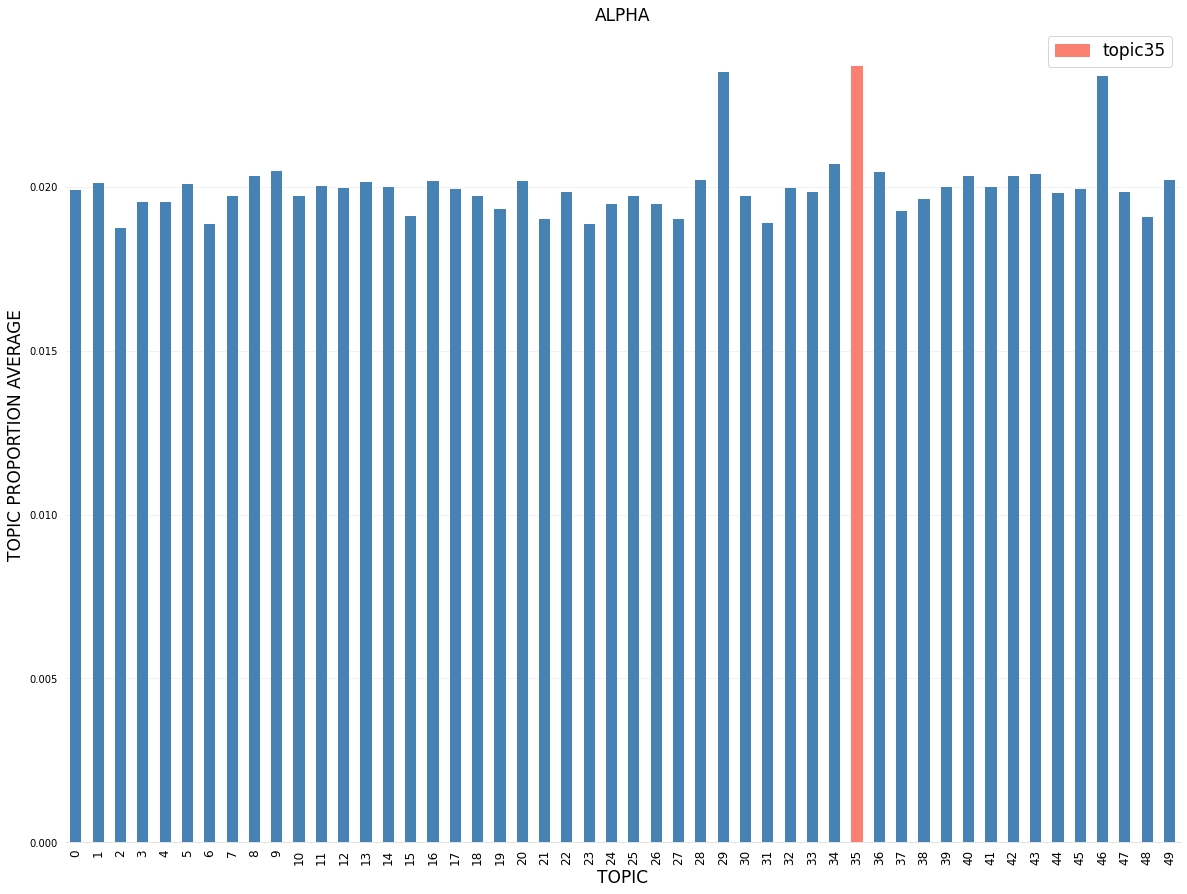

In [281]:
plot_topic_averages(cell_topics, 'alpha')


### Since the topics and genes are embedded in the same N-dimensional space, we can examine the spatial relation between topics and cell embeddings. We start by loading and plotting the gene embeddings using UMAP.

In [4]:
fpath=sourceDir+'embeddings/gene2vec_dim_'+str(emb)+'_iter_9.txt'

topic_emb, gene_emb=get_gene_and_topic_emb_umap(fpath, model)

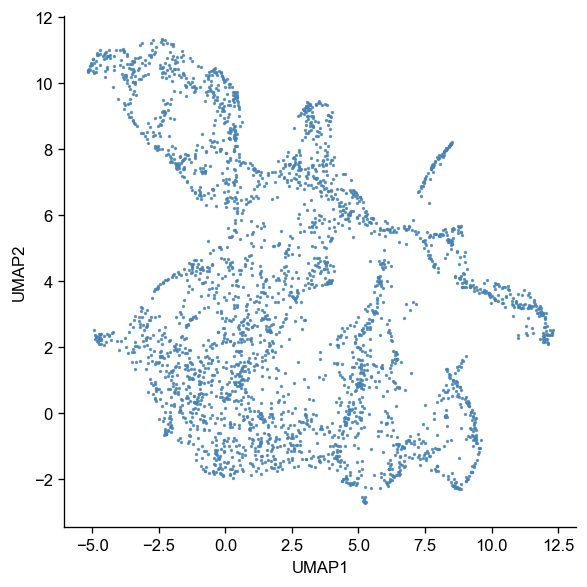

In [5]:
plot_umap(gene_emb) 

### We can examine the spatial relation between gene and topic embeddings. For example, we visualize how much a topic is enriched in genes and see if there is any relation with the topic spatial situation (red diamond). Each point represents a gene in th embedding space, and the color shows how much the genes enrich the given topic. As we can see, topic embeddings show high co-localization with groups of genes that enrich the given topic:

Adding topics


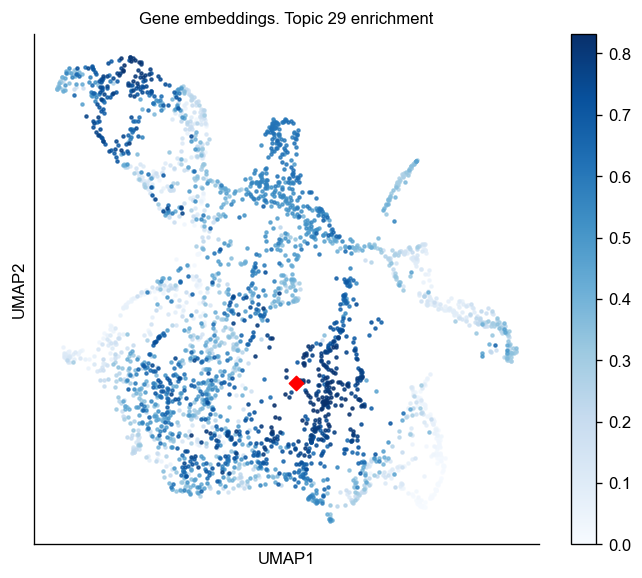

In [7]:
plot_topic_gene_proportion(gene_embeddings=gene_emb, model=model, topic_umap=topic_emb, topic=29)


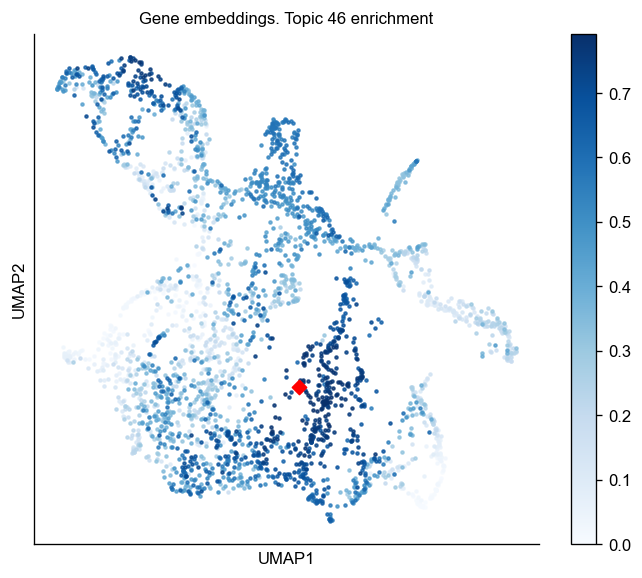

In [8]:
plot_topic_gene_proportion(gene_embeddings=gene_emb, model=model, topic_umap=topic_emb, topic=46)


### We cluster the genes. Since we don't have any initial information on identified gene clusters we use agglomerative clustering.

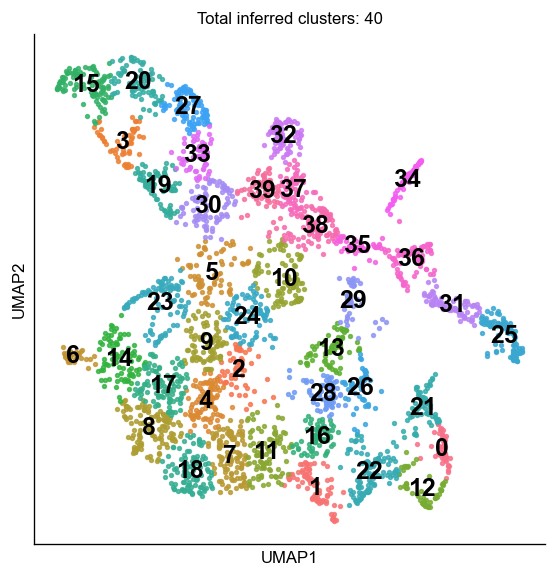

In [6]:
cluster_pred=plot_gene_clusters(gene_emb, name='human')

### We use a heatmap to inspect the topic intensity on the gene clusters:

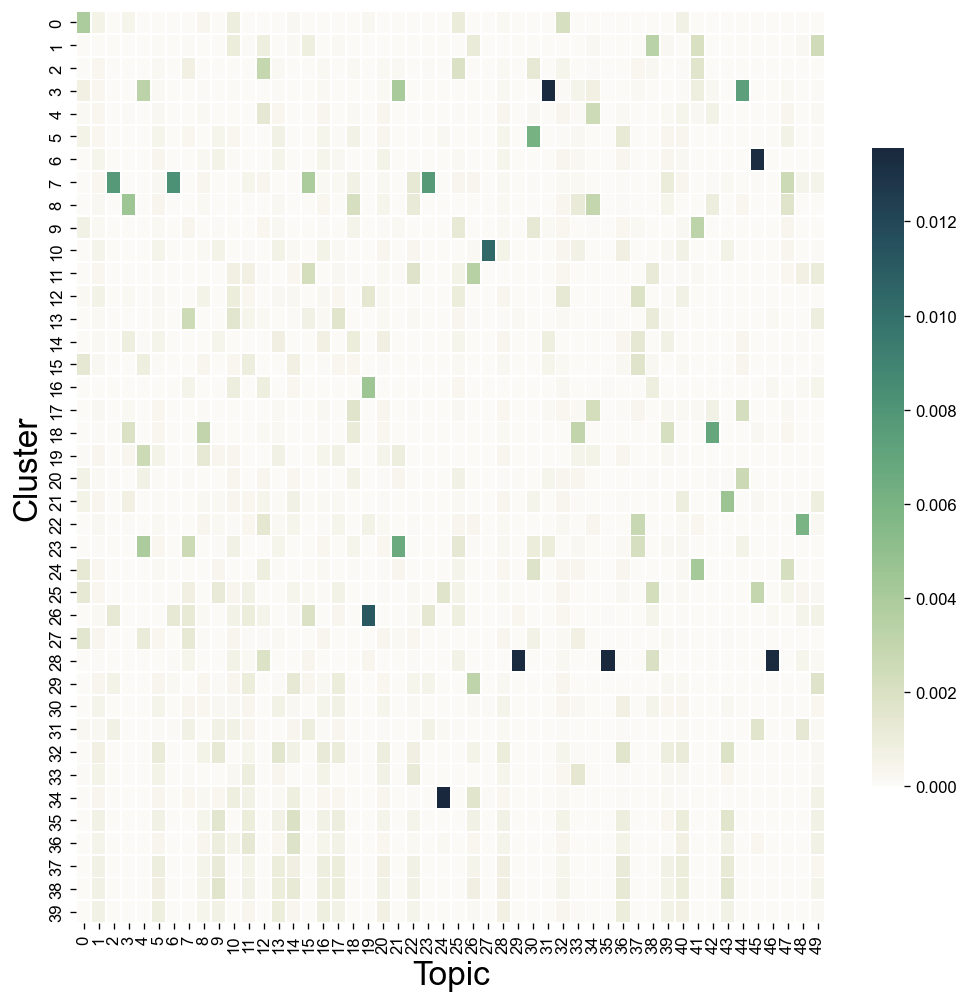

In [100]:
g=get_model_vocab(sourceDir)
beta=model.get_beta()
beta=beta.detach().numpy().T
beta=pd.DataFrame(beta, index=g)

gene_topic_intensity_heatmap(beta, cluster_pred, name='human')

### We note that specific topics, similar to cell clusters, dominate gene clusters. From this, we conclude that the topic representation can be used to discover additional sets of relevant or functional genes associated with cell types. Furthermore, the topics connect between cell types and genes: Cell types $\leftrightarrow$ Topics $\leftrightarrow$ Genes. From here, we can further explore these relationships via additional tests like GSEA and GWAS.